In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.feature_selection import RFECV, RFE


random_state = 7

In [2]:
df = pd.DataFrame.from_csv("Lyme86genes215samples.txt", sep="\s+").T
df.replace(to_replace={'Disease': {"Lyme": 1, "Others": 0}}, inplace=True)

X = df.drop(["Disease", "Sampletype", "Serology"], axis=1)
y = df['Disease']

print "Complete data set has %d samples (%d w/Lyme) and %d features." % \
                (X.shape[0], y[y == 1].count(), X.shape[1])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=random_state, 
                                                    stratify=y)
print "Training set has %d samples. Testing set has %d samples." % (len(X_train), len(X_test))

Complete data set has 215 samples (67 w/Lyme) and 86 features.
Training set has 172 samples. Testing set has 43 samples.


In [3]:
parameters={'estimator__C': [pow(2, i) for i in xrange(-25, 4, 1)]}
#est = LogisticRegression(class_weight="balanced")
est = LinearSVC(dual=True, class_weight="balanced")
rfe = RFECV(cv=5, estimator=est, n_jobs=1, scoring='neg_mean_squared_error', step=1, verbose=0)
clf = GridSearchCV(rfe, parameters, scoring='accuracy', n_jobs=8, cv=3, verbose=1)
clf.fit(X_train, y_train)

Fitting 3 folds for each of 29 candidates, totalling 87 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   17.0s
[Parallel(n_jobs=8)]: Done  87 out of  87 | elapsed:   46.3s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RFECV(cv=5,
   estimator=LinearSVC(C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
   n_jobs=1, scoring='neg_mean_squared_error', step=1, verbose=0),
       fit_params={}, iid=True, n_jobs=8,
       param_grid={'estimator__C': [2.9802322387695312e-08, 5.960464477539063e-08, 1.1920928955078125e-07, 2.384185791015625e-07, 4.76837158203125e-07, 9.5367431640625e-07, 1.9073486328125e-06, 3.814697265625e-06, 7.62939453125e-06, 1.52587890625e-05, 3.0517578125e-05, 6.103515625e-05, 0.0001220703125, 0.000244140625, 0.00048828125, 0.0009765625, 0.001953125, 0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=1)

Optimal number of features : 7
Recursive Feature Elimination (RFE) eliminated 79 features


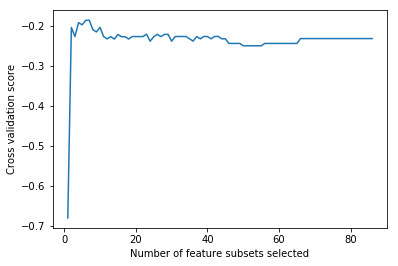

In [4]:
best_estimator = clf.best_estimator_

print("Optimal number of features : %d" % best_estimator.n_features_)
print("Recursive Feature Elimination (RFE) eliminated %d features" % (X_train.shape[1] - best_estimator.n_features_))

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of feature subsets selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(best_estimator.grid_scores_) + 1), best_estimator.grid_scores_)
plt.show()

In [5]:
from IPython.core.display import display, HTML

rfe_features = []
for (rank, name) in zip(best_estimator.ranking_, X.columns):
    if rank == 1:
        rfe_features.append(name)

s="""
<h2>List of %d genes found by RFE</h2>
<p>Note: the NCBI link will open the target in a new window or tab.</p>
<table>
""" % (best_estimator.n_features_)

ncbi_url = lambda gene: "https://www.ncbi.nlm.nih.gov/gene/?term=%s[Gene Name] AND Human[Organism]" % (gene)

s += "<tr>"
for (i, gene) in enumerate(rfe_features):
    if not i % 10:
        s += "</tr><tr>"
    s += """
    <td><a target=\"_blank\" href=\"%s\">%s</a></td>
    """ %(ncbi_url(gene), gene)
s += "</tr></table>"

display(HTML(s))

ANXA5,CD55,FDX1L,GRN,ICAM1,NCF1,TNFSF10


None


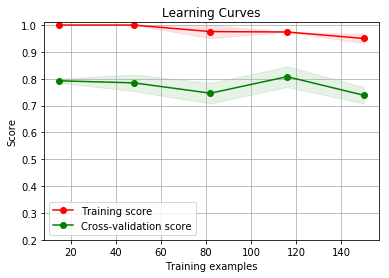

In [6]:
%matplotlib inline
from learning_curves import plot_learning_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit

def create_learning_curve(title, model):
    cv = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=random_state)                                     
    plot_learning_curve(model, title, X, y, (0.2, 1.01), cv=cv, n_jobs=1)
    
create_learning_curve("Learning Curves", est)

plt.show()

In [7]:
from classification_metrics import classification_metrics

est_predicted = clf.predict(X_test)
classification_metrics(y_test, est_predicted, ["Control", "Lyme"])

Accuracy was 79.07%

             precision    recall  f1-score   support

    Control       0.84      0.87      0.85        30
       Lyme       0.67      0.62      0.64        13

avg / total       0.79      0.79      0.79        43

Confusion Matrix: cols = predictions, rows = actual

                       Control           Lyme
        Control             26              4
           Lyme              5              8
